<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/CNN_bwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the necessary packages**

In [15]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [16]:
import torchvision
from torchvision import transforms as T
from matplotlib import pyplot as plt

In [17]:
from torch import nn
from torch.nn import functional as F

In [18]:
import time
import functorch as fc


# **Loading and preprocessing the data**

In [19]:
#Load the dataset
train_data = torchvision.datasets.KMNIST('./data', train=True, download=True)

In [20]:
# This loads data with both data conversion.
train_data = torchvision.datasets.KMNIST('./data', train=True, transform=T.ToTensor())

tensor(8)


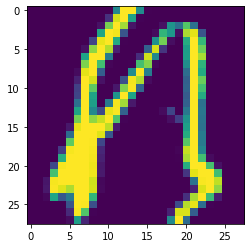

In [21]:
# We visualize the first sample of the dataset
plt.imshow(train_data.data[0])
print(train_data.targets[0])

In [22]:
# We use the loader to shuffle the elements of the dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

In [23]:
# We get the first element of the loader
xb, yb = next(iter(train_loader))

In [24]:
# Load the testset
test_data = torchvision.datasets.KMNIST('./data', train=False, transform=T.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# **Define Convolutional Neural Network**

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size, 2, 3, padding=1)

        self.conv2 = nn.Conv2d(2, 4, 3, padding=1)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4*14*14, 64)

        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.reshape((-1, 4*14*14))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.reshape(1, -1)
        return torch.softmax(x, 1)

In [26]:
# We check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# **Initialize the parameters**

In [27]:
# We initialize the parameters randomly and the model with an input size
cnn = SimpleCNN(1)

In [28]:
# Get the functional version of the model with functorch
fcnn, params = fc.make_functional(cnn)
fcnn(params, xb)

tensor([[0.0956, 0.1044, 0.0911, 0.0987, 0.1063, 0.0997, 0.0909, 0.0899, 0.1139,
         0.1095]], grad_fn=<SoftmaxBackward0>)

In [29]:
# We try our model with the first example
print(cnn(xb)[0])

tensor([0.0956, 0.1044, 0.0911, 0.0987, 0.1063, 0.0997, 0.0909, 0.0899, 0.1139,
        0.1095], grad_fn=<SelectBackward0>)



Calculate predictions

In [30]:
def pred(sample_size, loader, model):
  Xtrain = torch.randn(sample_size, 1, 28, 28)
  ytrain = torch.randn(sample_size)
  ypred = torch.randn(sample_size, 10)

  for i in range(sample_size):
    xb, yb = next(iter(loader))
    Xtrain[i] = xb
    ytrain[i] = yb
    ypred[i] = model(xb)

  return Xtrain, ytrain, ypred

In [31]:
Xtrain, ytrain, ypred= pred(500, train_loader, cnn)

# **Define accuracy**

In [32]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue.long()).float().mean()

In [33]:
# Average accuracy at initialization is 10% (random guessing).
accuracy(ytrain, ypred)

tensor(0.0860)

# **Define Cross-Entropy**

In [34]:
def cross_entropy(ytrue, ypred):
  print(torch.arange(0, ypred.shape[0]), ytrue.long())
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue.long()].log().mean()

In [35]:
print(cross_entropy(ytrain, cnn(Xtrain)))

tensor([0]) tensor([8, 2, 2, 0, 7, 3, 8, 8, 1, 2, 7, 4, 6, 5, 2, 3, 9, 2, 9, 3, 9, 0, 1, 4,
        1, 5, 6, 5, 2, 3, 5, 6, 8, 8, 7, 9, 8, 5, 5, 9, 2, 8, 6, 6, 3, 7, 6, 9,
        9, 9, 5, 2, 6, 9, 8, 3, 5, 1, 6, 3, 5, 7, 7, 3, 5, 6, 0, 5, 4, 4, 9, 6,
        5, 3, 0, 0, 6, 8, 2, 2, 2, 0, 1, 9, 1, 2, 8, 2, 7, 8, 7, 8, 4, 9, 8, 2,
        8, 7, 8, 0, 5, 8, 5, 2, 0, 9, 2, 4, 3, 0, 0, 8, 6, 5, 1, 4, 9, 2, 4, 4,
        7, 2, 6, 9, 2, 6, 4, 8, 6, 6, 1, 2, 3, 3, 6, 2, 1, 8, 7, 7, 5, 0, 5, 5,
        8, 9, 1, 2, 0, 7, 9, 9, 2, 3, 4, 4, 8, 7, 2, 2, 8, 8, 7, 2, 2, 5, 3, 0,
        3, 5, 0, 1, 4, 0, 0, 0, 5, 9, 0, 7, 7, 0, 9, 6, 9, 6, 9, 5, 7, 1, 0, 0,
        6, 0, 8, 1, 9, 1, 3, 7, 9, 5, 5, 1, 1, 4, 6, 5, 2, 1, 2, 4, 3, 3, 0, 5,
        1, 3, 5, 0, 6, 4, 0, 8, 4, 1, 3, 7, 1, 2, 9, 4, 1, 7, 0, 7, 1, 3, 4, 9,
        0, 4, 8, 4, 4, 6, 9, 2, 4, 5, 3, 5, 9, 1, 3, 5, 8, 9, 1, 5, 0, 5, 4, 0,
        4, 1, 0, 8, 5, 4, 3, 3, 8, 5, 0, 4, 2, 1, 5, 6, 0, 1, 4, 0, 0, 4, 2, 7,
        9, 0, 6, 8, 9, 2, 6,

# **Train and evaluate the network**

In [40]:
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters())
accuracies=[]
losses=[]

t=0
t0 = time.time()
for epoch in range(100):
  
  cnn.train()
  for i in range(499):
    xb, yb=Xtrain[i],ytrain[i]
    xb, yb = xb.to(device), yb.to(device)

    opt.zero_grad()
    ypred = cnn(xb)
    yb = yb.reshape(1)
    l = loss(ypred, yb.long())
    l.backward()
    opt.step()
    
  Xtest, ytest, ypredtest = pred(100, test_loader, cnn)
  accuracies.append(accuracy(ytest,ypredtest).item())
  loss2=0
  for i in range(ypredtest.size(0)):
    loss2+=loss(ypredtest[i], ytest[i].long())
  losses.append((loss2/ypredtest.size(0)).detach().item())

  loss1 = 0
  for i in range(Xtrain.size(0)):
    ytraini = ytrain[i].reshape(1)
    loss1 += loss(cnn(Xtrain[i]), ytraini.long())/Xtrain.size(0)

  # We add the execution time of the iteration
  t1=time.time()
  t+=t1-t0
  t0=t1

  print('Time', t, 'loss', loss1)

print('Final execution time', t)  
print('Mean execution time of an iteration', t/100)


Time 1.574310064315796 loss tensor(1.5170, grad_fn=<AddBackward0>)
Time 3.1355292797088623 loss tensor(1.5258, grad_fn=<AddBackward0>)
Time 4.6725475788116455 loss tensor(1.5157, grad_fn=<AddBackward0>)
Time 6.19948673248291 loss tensor(1.5131, grad_fn=<AddBackward0>)
Time 8.216404914855957 loss tensor(1.5131, grad_fn=<AddBackward0>)
Time 10.041527271270752 loss tensor(1.5151, grad_fn=<AddBackward0>)
Time 11.64114785194397 loss tensor(1.5131, grad_fn=<AddBackward0>)
Time 13.231597185134888 loss tensor(1.5170, grad_fn=<AddBackward0>)
Time 14.773425817489624 loss tensor(1.5135, grad_fn=<AddBackward0>)
Time 16.22345209121704 loss tensor(1.5316, grad_fn=<AddBackward0>)
Time 17.800456047058105 loss tensor(1.5151, grad_fn=<AddBackward0>)
Time 19.309540033340454 loss tensor(1.5151, grad_fn=<AddBackward0>)
Time 21.442222595214844 loss tensor(1.5181, grad_fn=<AddBackward0>)
Time 23.089740753173828 loss tensor(1.5173, grad_fn=<AddBackward0>)
Time 24.832623958587646 loss tensor(1.5131, grad_fn=<A

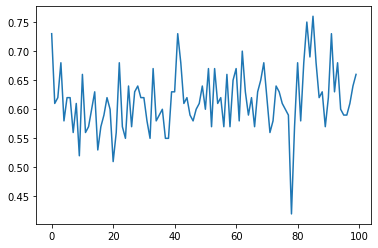

In [41]:
plt.plot(accuracies)

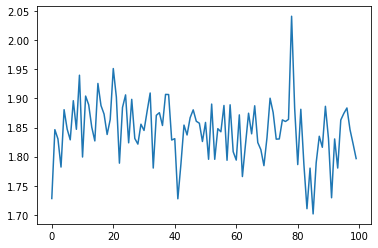

In [42]:
plt.plot(losses)